In [1]:
using ModelingToolkitStandardLibrary.Thermal

using ModelingToolkit, OrdinaryDiffEq
using ModelingToolkit: t_nounits as t, D_nounits as D

using CoolProp.CoolProp: PropsSI
using BenchmarkTools
using Plots
using Suppressor

In [2]:
# Helper functions
function calc_T(h, p)
    return PropsSI("T", "H", h, "P", p, fluid_name)
end

@register_symbolic calc_T(h::Real, p::Real);

In [3]:
# Components
@connector FluidPort begin
    @variables begin
        h(t), [guess=0.0]
        p(t), [guess=0.0]
        ṁ(t), [guess=0.0, connect = Flow]
    end
end

@mtkmodel Source begin
    @parameters begin
        h_source
        p_source
        ṁ_source
    end

    @components begin
        outlet = FluidPort()
    end

    @equations begin
        outlet.h ~ h_source
        outlet.p ~ p_source
        outlet.ṁ ~ ṁ_source
    end
end

@mtkmodel Sink begin
    @components begin
        inlet = FluidPort()
    end
end

@mtkmodel FluidElement begin

    @components begin
        inlet = FluidPort()
        outlet = FluidPort()
        heat_port = HeatPort()
    end

    @variables begin
        T(t)
        Q̇(t)
    end

    @equations begin
        # Heat port
        T ~ calc_T(inlet.h, inlet.p)
        heat_port.T ~ T
        heat_port.Q_flow ~ Q̇

        # Fluid ports
        outlet.h ~ inlet.h + Q̇/outlet.ṁ
        outlet.p ~ inlet.p
        outlet.ṁ + inlet.ṁ ~ 0 
    end
end;

In [4]:
# Combined element
@mtkmodel Element begin

    @parameters begin
        T_Al         
        dL          
        A_surface_over_dL
        α
    end

    begin
        G = A_surface_over_dL * dL * α
    end

    @components begin
        fluid_element = FluidElement()
        convection = ConvectiveConductor(G=G)
        wall = FixedTemperature(T=T_Al)
        inlet = FluidPort()
        outlet = FluidPort()
    end

    @variables begin
        T_fluid(t)
    end

    @equations begin
        connect(inlet, fluid_element.inlet)
        connect(fluid_element.heat_port, convection.fluid)
        connect(convection.solid, wall.port)
        connect(fluid_element.outlet, outlet)
        T_fluid ~ fluid_element.T
    end
end;

In [5]:
# System
@component function HeatExchanger(N_elements; h_source, p_source, ṁ_source,
    T_Al, dL, A_surface_over_dL, α, name)

    pars = @parameters begin
        h_source = h_source
        p_source = p_source
        ṁ_source = ṁ_source
        T_Al = T_Al      
        dL = dL            
        A_surface_over_dL = A_surface_over_dL
        α = α
    end

    ports = @named begin
        source = Source(h_source=h_source, p_source=p_source, ṁ_source=ṁ_source)
        sink = Sink()
    end
    
    elements = []
    for i in 1:N_elements
        x = Element(; name=Symbol("element$i"), 
           T_Al=ParentScope(T_Al), 
           dL=ParentScope(dL), 
           A_surface_over_dL=ParentScope(A_surface_over_dL),
           α = ParentScope(α))
        push!(elements, x)
    end

    eqs = [
        connect(source.outlet, elements[1].inlet)
        connect(elements[end].outlet, sink.inlet)
    ]

    for i in 1:N_elements-1
        push!(eqs, connect(elements[i].outlet, elements[i+1].inlet))
    end

    ODESystem(eqs, t, [], pars; name, systems=[ports; elements])
end;

In [6]:
## Inputs
# Fluid parameters
global fluid_name = "Parahydrogen"
ṁ = 10e-3            # kg/s
T_in = 70               # K
p_in = 350e5           # Pa
h_in = PropsSI("H", "T", T_in, "P", p_in, fluid_name);

# Wall parameters
T_Al = 50 + 273.15      # K
L = 10.0                 # m
dL = 0.1                # m
N_elements = Int(L/dL);

# Convection
Diameter = 10e-3       # m
A_surface_over_dL = π*Diameter
α = 3000.0;

In [7]:
sys = @suppress begin
    @mtkbuild sys = HeatExchanger(N_elements; h_source=h_in, p_source=p_in, ṁ_source=ṁ,
                T_Al=T_Al, dL=dL, A_surface_over_dL=A_surface_over_dL, α=α)
end;

In [8]:
prob = ODEProblem(sys, [], (0, 10.0));

In [9]:
L_array, T_array = @btime begin
    
    sol = solve(prob, Tsit5())
    L_array = (1:N_elements)*dL
    T_array = [sol[getproperty(sys, Symbol("element$i")).T_fluid][end] for i in 1:N_elements];

    return L_array, T_array
end;

  1.815 s (140070 allocations: 3.86 MiB)


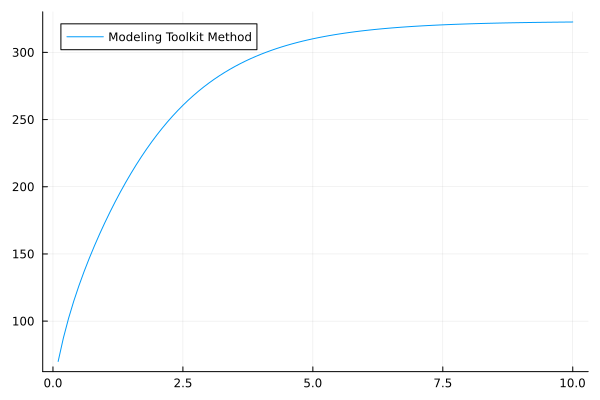

In [10]:
# Create comparison plot
p = plot(
    L_array, T_array,
    label="Modeling Toolkit Method"
)

display(p)